# Notebook to make Fig. 5

In [3]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
from scipy.stats import gaussian_kde

import json
import random
import sys
import os

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

from helper_functions import *

style.use('plotting.mplstyle')

### Load data

This data is calculated in `make_figure_04.ipynb` and is prerequesite for this notebook.

In [7]:
if os.path.exists('predicted_spins_dict_pp.json') and os.path.exists('observed_spins_dict_pp.json'): 
    
    # Load in the predicted and observed draws 
    with open('predicted_spins_dict_pp.json', 'r') as f: 
        pred_spins = json.load(f)
    with open('observed_spins_dict_pp.json', 'r') as f: 
        obs_spins = json.load(f)

else: 
    print('Go to make_figure_04.ipynb notebook to generate predicted_spins_dict_pp.json and observed_spins_dict_pp.json')

### Calculate fraction of events in catalog overpredicted

In [36]:
percentages_dict = {}

for pop,pop_key in enumerate(['pop1', 'pop2', 'pop3']):
    
    percentages_dict_pop = {}
    
    for param_key in ['chi1', 'chi2', 'cost1', 'cost2']: 
        
        # Get and sort predicted versus observed values for this parameter
        all_pred = np.zeros(np.asarray(pred_spins[pop_key][param_key]).shape)
        all_obs = np.zeros(np.asarray(pred_spins[pop_key][param_key]).shape)
        
        for i in range(all_pred.shape[0]): 
            all_pred[i,:] = np.sort(pred_spins[pop_key][param_key][i])
            all_obs[i,:] = np.sort(obs_spins[pop_key][param_key][i])

        # Binning
        all_x = np.concatenate(all_pred)
        all_y = np.concatenate(all_obs)
        xmin = np.min(all_x)
        xmax = np.max(all_x)
        numbins = np.linspace(xmin, xmax, 50)
        dx = numbins[1] - numbins[0]
        
        # Calculate fraction in each bin above the line y=x
        percentages = []
        for i in np.arange(len(numbins)-1):
            lower_bound = numbins[i]
            upper_bound = numbins[i+1]
            mask = (all_x >= lower_bound) & (all_x <= upper_bound)
            x_vals = all_x[mask]
            y_vals = all_y[mask]
            # percentage of values above y=x
            if len(x_vals) == 0:
                per = 0
            else:
                per = sum(y_vals > x_vals) / len(x_vals)
            percentages += [per]
            
        percentages_dict_pop[param_key] = {'percentages': np.asarray(percentages), 'bins':numbins[:-1]+0.5*dx}
        
    percentages_dict[pop_key] = percentages_dict_pop

### Make figure

In [37]:
labels_dict = {
    'pop1':r'$\mathrm{\textsc{HighSpinPrecessing}}$', 
    'pop2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop3':r'$\mathrm{\textsc{LowSpinAligned}}$'
}

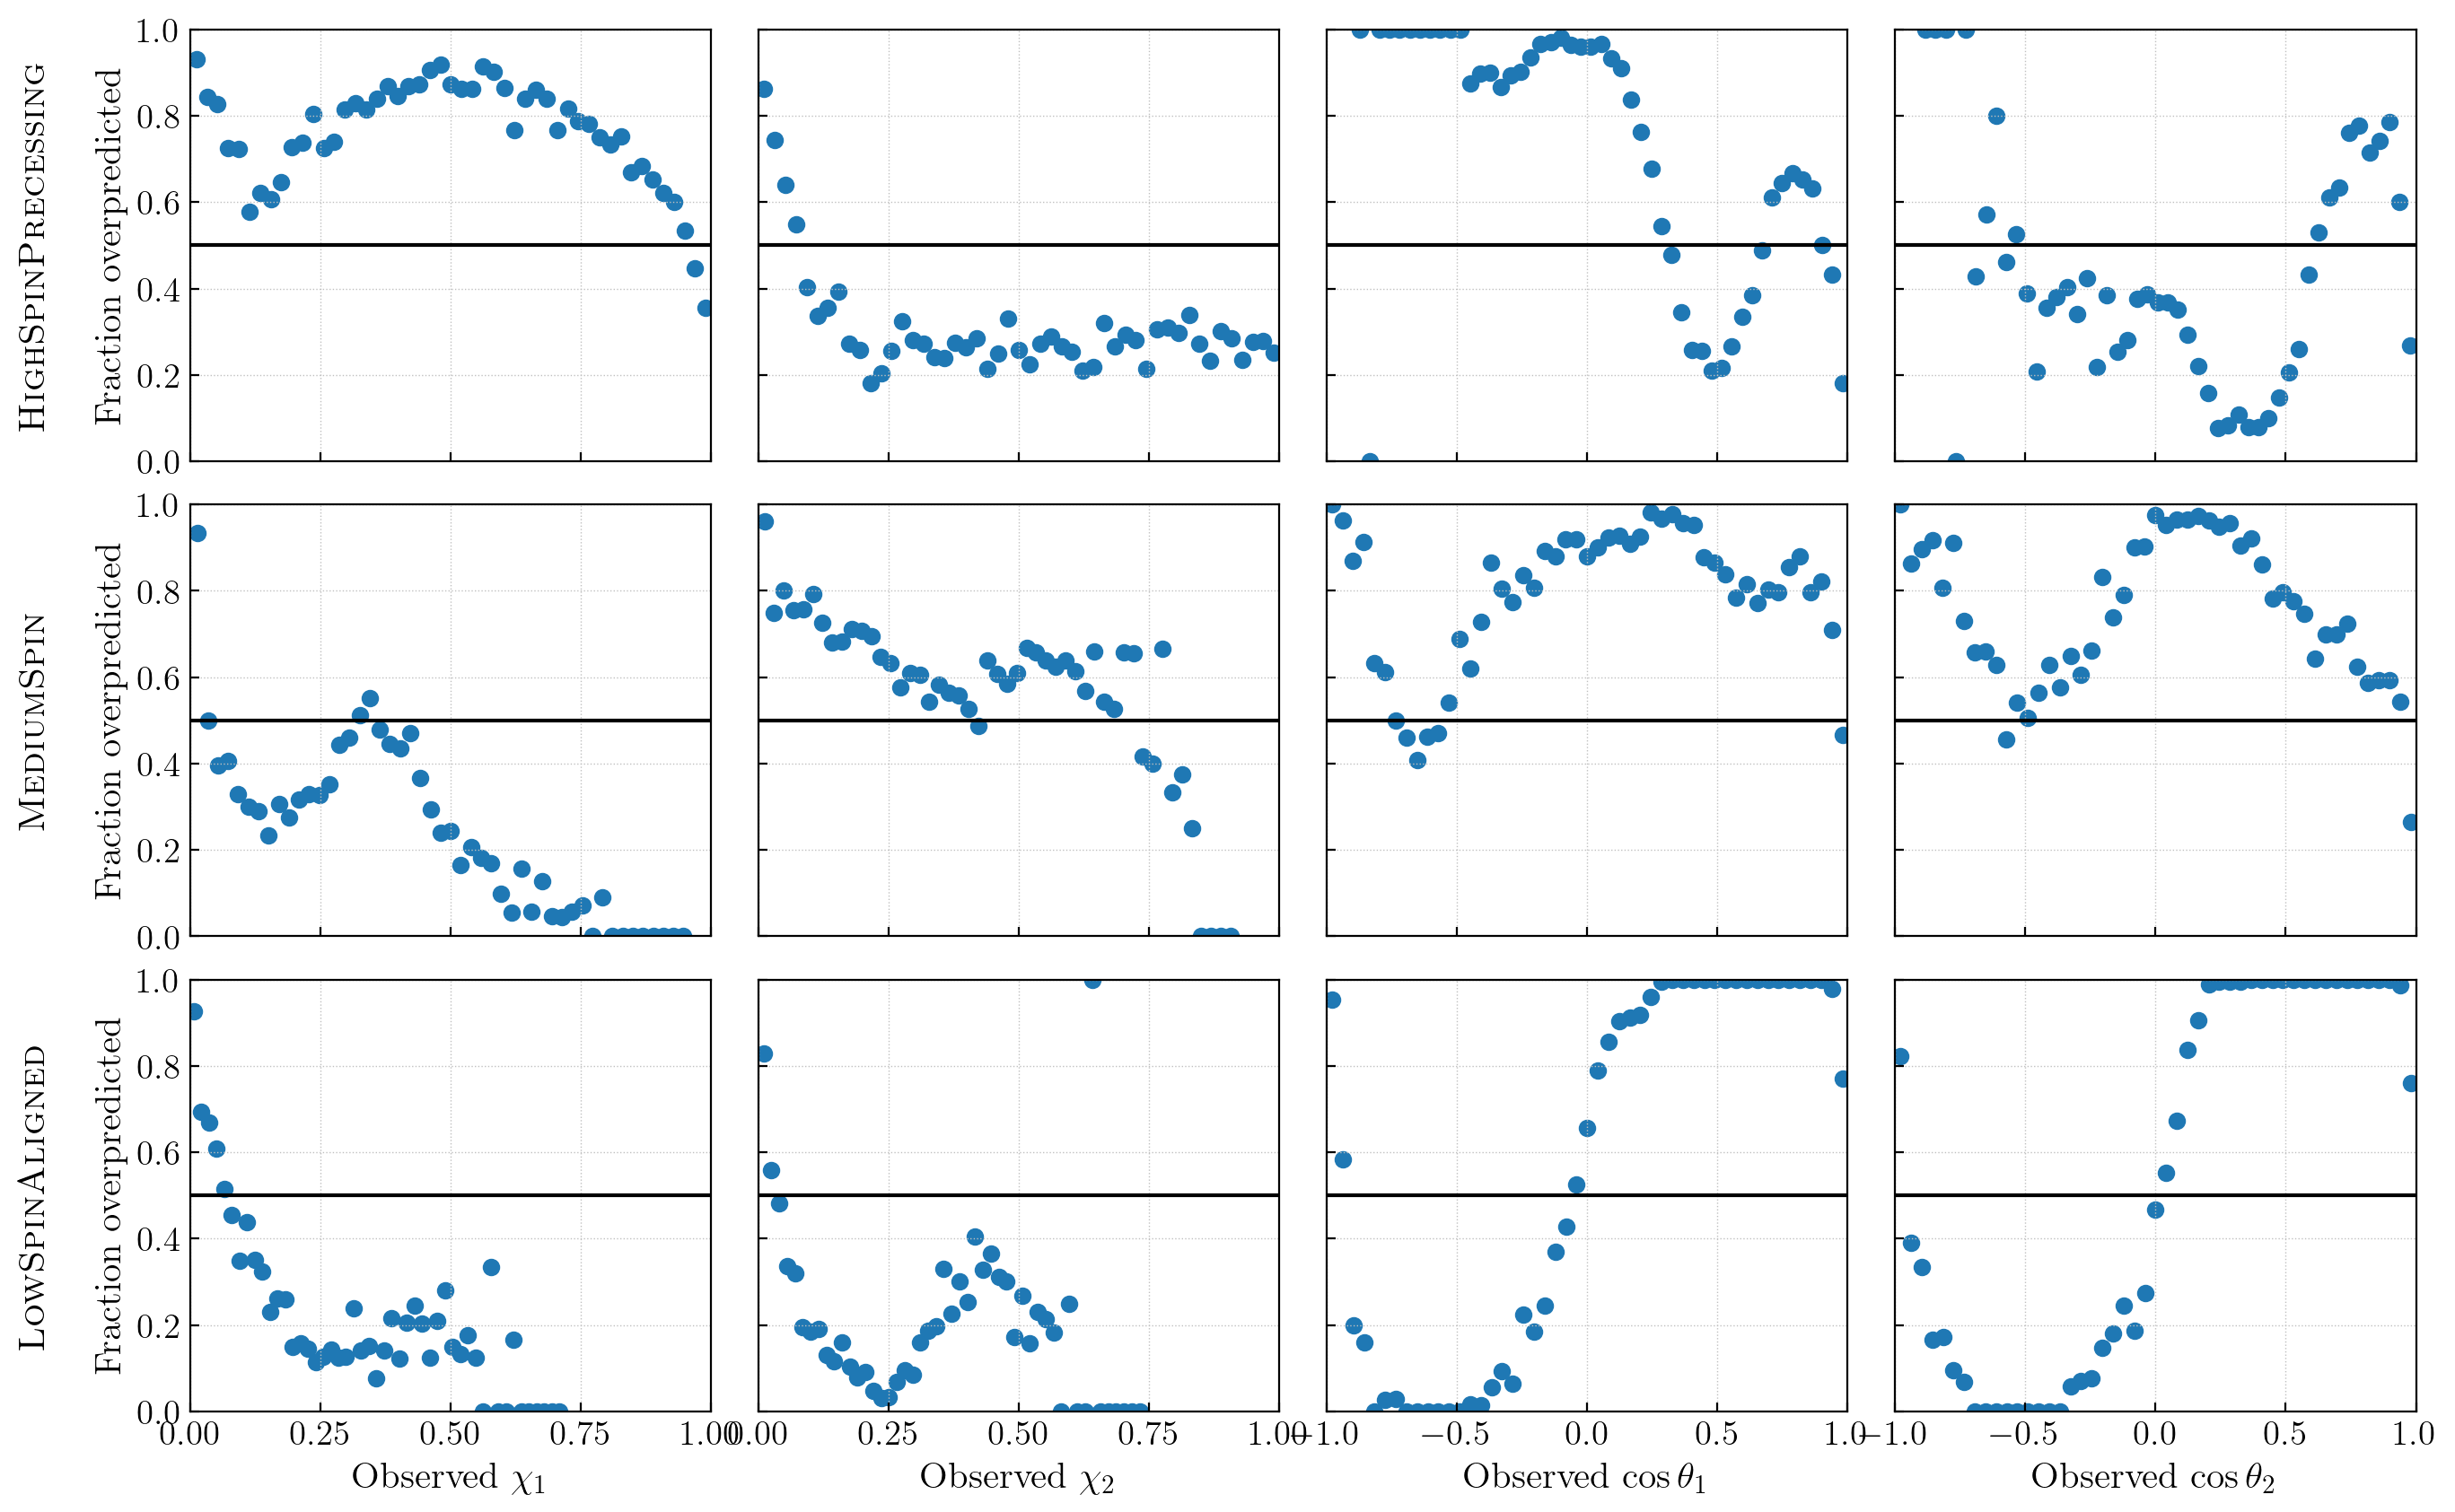

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,10))

for i,key in enumerate(['pop1', 'pop2', 'pop3']):
    
    # spin magnitudes
    axes[i][0].scatter(percentages_dict[key]['chi1']['bins'], percentages_dict[key]['chi1']['percentages'], color='#1f78b4')
    axes[i][0].plot([0, 1], [0.5, 0.5], color='k') # horizontal line
    axes[i][0].set_xlim(0,1)
    axes[i][0].set_ylim(0,1)
    
    axes[i][1].scatter(percentages_dict[key]['chi2']['bins'], percentages_dict[key]['chi2']['percentages'], color='#1f78b4')
    axes[i][1].plot([0, 1], [0.5, 0.5], color='k')
    axes[i][1].set_xlim(0,1)
    axes[i][1].set_ylim(0,1)
    
    # tilt angles
    axes[i][2].scatter(percentages_dict[key]['cost1']['bins'], percentages_dict[key]['cost1']['percentages'], color='#1f78b4')
    axes[i][2].plot([-1, 1], [0.5, 0.5], color='k')
    axes[i][2].set_xlim(-1,1)
    axes[i][2].set_ylim(0,1)
    
    axes[i][3].scatter(percentages_dict[key]['cost2']['bins'], percentages_dict[key]['cost2']['percentages'], color='#1f78b4')
    axes[i][3].plot([-1, 1], [0.5, 0.5], color='k')
    axes[i][3].set_xlim(-1,1)
    axes[i][3].set_ylim(0,1)
    
    # set label
    axes[i][0].set_ylabel(f'{labels_dict[key]}\n\n Fraction overpredicted', fontsize=15)
        
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])
    
axes[2][0].set_xlabel(r'Observed $\chi_1$', fontsize=15)
axes[2][1].set_xlabel(r'Observed $\chi_2$', fontsize=15)
axes[2][2].set_xlabel(r'Observed $\cos\theta_1$', fontsize=15)
axes[2][3].set_xlabel(r'Observed $\cos\theta_2$', fontsize=15)

for ax in axes: 
    for i,a in enumerate(ax):
        a.grid(ls=':', color='silver', lw=0.5)
        if i!=0: 
            a.set_yticklabels([])
        
plt.subplots_adjust(hspace=0.1, wspace=0.09)
    
plt.savefig('figure_05_temp.pdf',bbox_inches='tight')
plt.show()